In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr, kruskal, ttest_ind, f_oneway, shapiro, mannwhitneyu, levene
import pingouin as pg
import cloudpickle
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def fImpReal(data, feature, alpha=0.05):
    print('Importance of variable', feature, '\n')
    x = data[feature]
    y = data['payroll_ind']
    
    x0 = x.loc[y==0]
    x1 = x.loc[y==1]
    
    lev = levene(x0, x1)
    if lev[1]<alpha:
        print('Variance Assumption Invalid: Test Results not Accurate')
    else:
        print('Variance Assumption Valid')
    
    s1 = shapiro(x0)[1]
    s2 = shapiro(x1)[1]
    if s1<alpha or s2<alpha:
        print('Normality Assumption Invalid: Test Results not Accurate\n')
    else:
        print('Normality Assumption Valid\n')
    
    pb = pointbiserialr(y, x)
    print('Point Biserial:', np.round(pb[0], 3))
    if pb[1]>alpha:
        print('Not Important')
    else:
        print('Important')
        
    ktest = kruskal(y, x, nan_policy='omit')
    print('Kruskal-Wallis H-test (No need for normality assumption):', np.round(ktest[0], 3))
    if ktest[1]>alpha:
        print('Not Important')
    else:
        print('Important')
        
    welch = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
    print('Welch t-Test (No need for variance assumption):', np.round(welch[0], 3))
    if welch[1]>alpha:
        print('Not Important')
    else:
        print('Important --> Checking post-hoc Games Howell test')
        gamesHowell = pg.pairwise_gameshowell(data=data, dv=feature, between='payroll_ind')
        if gamesHowell.iloc[0, :]['pval'] < alpha:
            print('Importance Confirmed')
        else:
            print('Importance Not Confirmed')
        
        
    mann = mannwhitneyu(x0, x1)
    print('Mann-Whitney U Test (No need for normality assumption):', np.round(mann[0], 3))
    if mann[1]>alpha:
        print('Not Important')
    else:
        print('Important')

def getTransactions(rem_act_no, bene_act_no):
    return train[(train['rem_act_no_dummy']==rem_act_no) & (train['bene_act_no_dummy']==bene_act_no)]

In [3]:
cloudpickle.dump(fImpReal, open('fImpReal.fn', 'wb'))
cloudpickle.dump(getTransactions, open('getTransactions.fn', 'wb'))

### Loading Data

In [4]:
train = pd.read_csv('Data/Train.csv', index_col=[0])
trans_date = train['transaction_val_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train['transaction_val_dt'] = trans_date

test = pd.read_csv('Data/Test_fin.csv', index_col=0)
trans_date = test['transaction_val_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['transaction_val_dt'] = trans_date

In [5]:
train.head()

,rem_company_id_dummy,rem_act_no_dummy,bene_act_no_dummy,txn_amt,transaction_val_dt,yearmonth,txn_type,rem_company_ind,payroll_ind
txn_refr_key_dummy,,,,,,,,,
1,1000000000,5000000,8000000,1.458730,2020-09-17,202009,CROSS BORDER,Consumer,0
4,1000000020,5000200,8000200,1.269716,2020-09-30,202009,CROSS BORDER,Communications,0
5,1000000030,5000300,8000300,1.190682,2020-09-22,202009,CROSS BORDER,Industrials,0
7,1000000050,5000500,8000500,5.657271,2020-09-29,202009,CROSS BORDER,Technology,0
8,1000000020,5000200,8000600,1.239628,2020-09-29,202009,CROSS BORDER,Communications,0


## Grouped Analysis

In [6]:
rem_bene = train.groupby(['rem_act_no_dummy', 'bene_act_no_dummy'])
# rem_bene = train.groupby(['rem_company_id_dummy', 'bene_act_no_dummy'])
rem_bene_groups = rem_bene.groups

In [7]:
counts = rem_bene.count()['payroll_ind']
sol = rem_bene.mean()['payroll_ind'].values.reshape(-1, 1)
groupDF = pd.DataFrame(data=np.append(counts.values.reshape(-1, 1), sol, axis=1), index=counts.index.to_flat_index(), columns=['n_txn', 'payroll_ind'])
groupDF = groupDF.astype({'n_txn':int, 'payroll_ind':int})
groupDF

,n_txn,payroll_ind
"(5000000, 8000000)",3,0
"(5000000, 8538500)",4,0
"(5000000, 8813800)",3,0
"(5000000, 9768200)",7,0
"(5000000, 9784300)",2,0
...,...,...
"(5742900, 74564200)",1,0
"(5743300, 74530200)",1,0
"(5743500, 74532600)",1,0
"(5743600, 74560500)",1,0


In [8]:
groupDF

,n_txn,payroll_ind
"(5000000, 8000000)",3,0
"(5000000, 8538500)",4,0
"(5000000, 8813800)",3,0
"(5000000, 9768200)",7,0
"(5000000, 9784300)",2,0
...,...,...
"(5742900, 74564200)",1,0
"(5743300, 74530200)",1,0
"(5743500, 74532600)",1,0
"(5743600, 74560500)",1,0


In [9]:
groupDF['rem_company_id_dummy'] = rem_bene['rem_company_id_dummy'].first().values

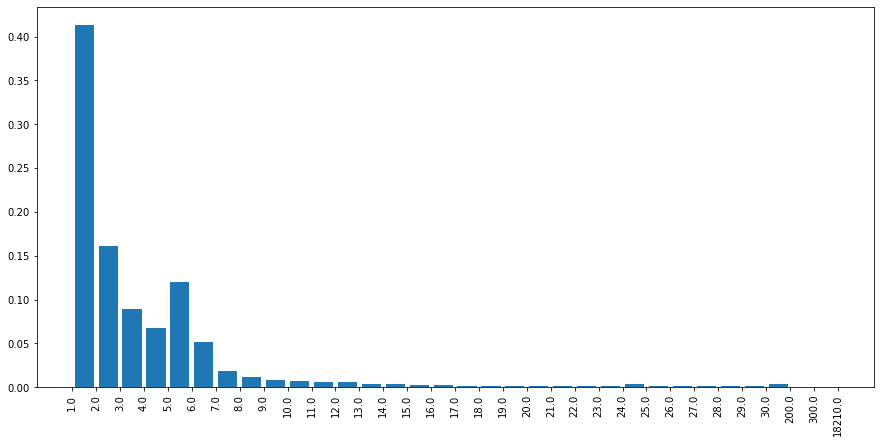

In [10]:
buckets = list(np.linspace(1, 30, 30)) + [200, 300, max(counts)]
freq, loc = np.histogram(groupDF.n_txn, buckets)
freq_ = freq/sum(freq)
plt.figure(figsize=(15, 7))
plt.bar(range(len(freq_)), freq_)
plt.xticks([xx-0.5 for xx in range(len(freq)+1)], loc, rotation=90)
plt.show()

In [11]:
txn_amt_grp_var = rem_bene['txn_amt'].var(ddof=0)
groupDF['txn_amt_var'] = txn_amt_grp_var
groupDF['txn_amt_mean'] = rem_bene['txn_amt'].mean()

In [12]:
fImpReal(groupDF, 'txn_amt_var')
fImpReal(groupDF, 'txn_amt_mean')

Importance of variable txn_amt_var 

Variance Assumption Valid
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: -0.001
Not Important
Kruskal-Wallis H-test (No need for normality assumption): 220209.295
Important
Welch t-Test (No need for variance assumption): 2.368
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 1168434380.0
Important
Importance of variable txn_amt_mean 

Variance Assumption Valid
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: -0.001
Not Important
Kruskal-Wallis H-test (No need for normality assumption): 643102.821
Important
Welch t-Test (No need for variance assumption): 3.89
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 946576334.0
Important


In [13]:
delta = (rem_bene['transaction_val_dt'].max()-rem_bene['transaction_val_dt'].min()).apply(lambda x: x.days)
groupDF['txn_rate'] = groupDF['n_txn']/delta
groupDF['avg_txn_time'] = delta/(groupDF['n_txn']-1)
groupDF.loc[groupDF['txn_rate'] == np.inf, 'txn_rate'] = np.nan
groupDF = groupDF.fillna(groupDF.mean())

In [14]:
def getGapVar(x):
    if len(x)>1:
        return x['transaction_val_dt'].sort_values().diff()[1:].apply(lambda x: x.days).var(ddof=0)
    else:
        return 0
    
varTxnGap = rem_bene.apply(getGapVar)
groupDF['varTxnGap'] = varTxnGap

In [15]:
def getAvgTxnPerDay(x):
    return len(x)/x['transaction_val_dt'].nunique()

avgTxnPerDay = rem_bene.apply(getAvgTxnPerDay)
groupDF['avgTxnPerDay'] = avgTxnPerDay

In [16]:
# i = 3
# getTransactions(groupDF.iloc[i].name[0], groupDF.iloc[i].name[1])['transaction_val_dt'].sort_values().diff()[1:].apply(lambda x: x.days).var()
# # getTransactions(5080300, 8812000)['transaction_val_dt'].sort_values().diff()

In [17]:
def ddMean(x):
    days = x.apply(lambda x: x.day)
    return np.mean(days), np.var(days, ddof=0) 
    
day_stats = rem_bene['transaction_val_dt'].apply(ddMean)
groupDF['dd_mean'], groupDF['dd_var'] = day_stats.str

In [18]:
groupDF

,n_txn,payroll_ind,rem_company_id_dummy,txn_amt_var,txn_amt_mean,txn_rate,avg_txn_time,varTxnGap,avgTxnPerDay,dd_mean,dd_var
"(5000000, 8000000)",3,0,1000000000,0.000954,1.480575,0.025641,58.500000,90.250000,1.0,11.333333,24.222222
"(5000000, 8538500)",4,0,1000000000,0.038843,1.337178,0.250000,5.333333,11.555556,1.0,11.000000,38.000000
"(5000000, 8813800)",3,0,1000000000,0.465905,1.553873,0.081081,18.500000,72.250000,1.0,15.666667,16.888889
"(5000000, 9768200)",7,0,1000000000,0.003921,1.081052,0.041667,28.000000,73.000000,1.0,21.285714,47.346939
"(5000000, 9784300)",2,0,1000000000,0.000000,1.218439,0.181818,11.000000,0.000000,1.0,9.500000,30.250000
...,...,...,...,...,...,...,...,...,...,...,...
"(5742900, 74564200)",1,0,1000005090,0.000000,3.572418,0.079598,35.559001,0.000000,1.0,26.000000,0.000000
"(5743300, 74530200)",1,0,1000038290,0.000000,1.054750,0.079598,35.559001,0.000000,1.0,26.000000,0.000000
"(5743500, 74532600)",1,0,1000024130,0.000000,7.023683,0.079598,35.559001,0.000000,1.0,26.000000,0.000000
"(5743600, 74560500)",1,0,1000038310,0.000000,5.312126,0.079598,35.559001,0.000000,1.0,26.000000,0.000000


In [19]:
pickle.dump(groupDF, open('groupDF.sav', 'wb'))

In [20]:
fImpReal(groupDF, 'txn_rate')

Importance of variable txn_rate 

Variance Assumption Invalid: Test Results not Accurate
Normality Assumption Invalid: Test Results not Accurate

Point Biserial: -0.021
Important
Kruskal-Wallis H-test (No need for normality assumption): 527047.924
Important
Welch t-Test (No need for variance assumption): 43.965
Important --> Checking post-hoc Games Howell test
Importance Confirmed
Mann-Whitney U Test (No need for normality assumption): 2502347208.0
Important


In [21]:
multi_pay_bene = []
bene_groups = train.groupby('bene_act_no_dummy')['payroll_ind'].mean()
for bene_acc, pind in bene_groups.items():
    if pind>0 and pind<1:
        multi_pay_bene.append((bene_acc, pind))

print('Number of bene acc where both pay and non-pay:', len(multi_pay_bene))

Number of bene acc where both pay and non-pay: 2065


In [22]:
bene_gps_n_comp = train.groupby('bene_act_no_dummy')['rem_company_id_dummy'].nunique()
multi_comp_bene = []
for bene_acc, n_comp in bene_gps_n_comp.items():
    if n_comp>1:
        multi_comp_bene.append((bene_acc, n_comp))

print('Number of bene acc where multiple companies:', len(multi_comp_bene))
comp_counts = [val[1] for val in multi_comp_bene]
print('Multiple companies count distribution')
print(np.unique(comp_counts, return_counts=True))

Number of bene acc where multiple companies: 9016
Multiple companies count distribution
(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  20,  22,  24,  25,  26,  34,  35,  36,  44,
        45,  52, 168]), array([8326,  486,   78,   27,   24,   14,   11,   11,   10,    4,    1,
          1,    3,    1,    1,    2,    4,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1]))


In [23]:
pickle.dump(groupDF, open('groupDF.sav', 'wb'))